In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from api.BinanceData import BinanceData
from utils.CleanData import CleanData
from variables.Returns import Returns
from variables.Target import Target
from variables.TradingIndicators import TradingIndicators
from models.Models import CryptoModel

/Users/noe/Documents/BigData S.Barthelemy/crypto-price-movement-intraday-prediction/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import de données
BinanceData = BinanceData()
data = BinanceData.load_data("BTCUSDT", days=1460) # 4 ans de données
print(data.head(2))
print(len(data))

       open_time            open            high             low  \
0  1633728300000  54146.60000000  54331.69000000  54121.00000000   
1  1633728600000  54278.72000000  54278.72000000  54141.60000000   

            close        volume     close_time quote_asset_volume  \
0  54278.72000000  138.64590000  1633728599999   7515690.83386520   
1  54186.22000000   88.99707000  1633728899999   4823947.99515550   

   number_of_trades taker_buy_base   taker_buy_quote ignore  
0              5177    88.79192000  4812620.66993300      0  
1              3666    27.13175000  1470154.00282060      0  
420465


In [4]:
# Nettoyage des données 
cleaner = CleanData()
cleaned_data = cleaner.clean_klines_data(data)

print(cleaned_data.index.name)
print(cleaned_data.tail(3))

open_time
                          high        low      close    volume  \
open_time                                                        
2025-10-07 21:15:00  122160.32  121958.14  122156.58  32.91528   
2025-10-07 21:20:00  122156.58  122071.99  122138.40  23.72100   
2025-10-07 21:25:00  122256.50  122138.40  122256.49  23.90548   

                     quote_asset_volume  number_of_trades  taker_buy_quote  
open_time                                                                   
2025-10-07 21:15:00        4.018550e+06             15527     2.087387e+06  
2025-10-07 21:20:00        2.896555e+06              7843     1.710561e+06  
2025-10-07 21:25:00        2.921587e+06              4478     2.522587e+06  


In [5]:
# Export des données pour travailler sur un ficheir Excel plutôt que de requêter l'API Binance à chaque fois
print(len(cleaned_data))
cleaned_data.to_csv("../data/clean_dataset.csv", index=True)

420465


In [2]:
# Import des données depuis le fichier Excel
data = pd.read_csv("../data/clean_dataset.csv", index_col=0)

# Création des variables rendement et la cible
data["return"] = Returns.return_(data['close'])
# data["return_10"] = Returns.return_10(data['close'])
data["target"] = Target.compute(data["return"])

# ajout des indicateurs techniques
# data = TradingIndicators.add_sma(data, price_col="close", window=20, new_col="SMA_20")
data = TradingIndicators.add_ema(data, price_col="close", window=12, new_col="EMA_12")
data = TradingIndicators.add_macd(data, price_col="close")
data = TradingIndicators.add_bollinger_bands_width(data, price_col="close")
data = TradingIndicators.add_rsi(data, price_col="close")
data = TradingIndicators.add_atr(data, high_col="high", low_col="low", close_col="close", window=14, new_col="ATR_14")
data = TradingIndicators.add_high_low_range(data, high_col="high", low_col="low")
data = TradingIndicators.add_buy_pressure(data, high_col="high", low_col="low", close_col="close")
data = TradingIndicators.add_volume_pressure(data, taker_buy_col="taker_buy_quote", total_volume_col="quote_asset_volume")
data = TradingIndicators.add_realized_volatility(data, returns_col="return", window=14)

data.index = pd.to_datetime(data.index)

print(data.tail(3))
print(data["target"].value_counts())
print(data.columns)

                          high        low      close    volume  \
open_time                                                        
2025-10-07 21:15:00  122160.32  121958.14  122156.58  32.91528   
2025-10-07 21:20:00  122156.58  122071.99  122138.40  23.72100   
2025-10-07 21:25:00  122256.50  122138.40  122256.49  23.90548   

                     quote_asset_volume  number_of_trades  taker_buy_quote  \
open_time                                                                    
2025-10-07 21:15:00        4.018550e+06             15527     2.087387e+06   
2025-10-07 21:20:00        2.896555e+06              7843     1.710561e+06   
2025-10-07 21:25:00        2.921587e+06              4478     2.522587e+06   

                       return  target         EMA_12        MACD  MACD_Signal  \
open_time                                                                       
2025-10-07 21:15:00  0.001346       1  122037.553868  165.851418   182.898083   
2025-10-07 21:20:00 -0.000149      

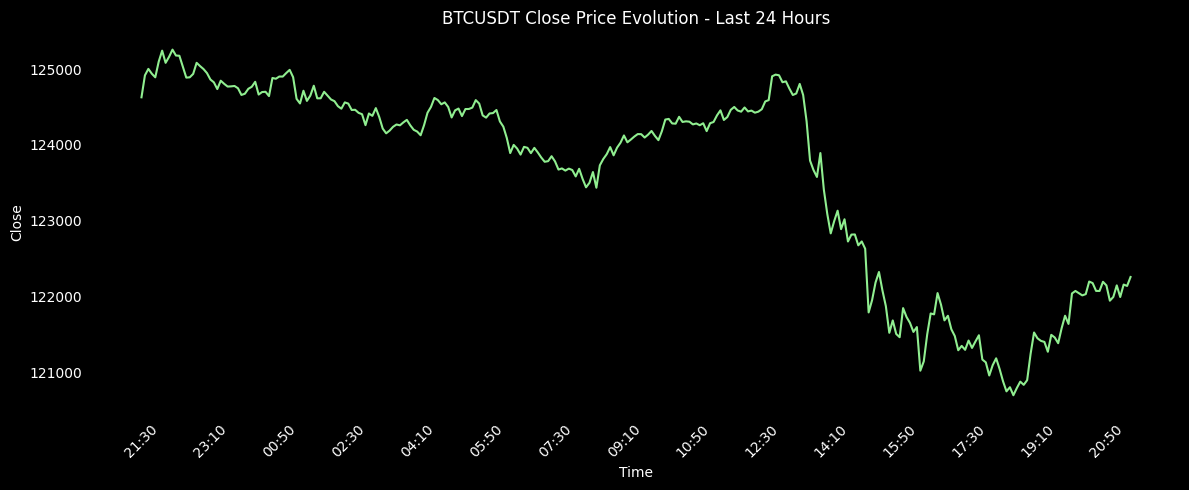

In [7]:
df = data[['close']].tail(288).copy()

x = df.index
y = df['close']

plt.figure(figsize=(12,5), facecolor='black')

# Plot
plt.plot(x, y, color="lightgreen", linestyle='-')

# Titres et labels
plt.title("BTCUSDT Close Price Evolution - Last 24 Hours", color='white')
plt.xlabel("Time", color='white')
plt.ylabel("Close", color='white')

# Fond des axes
ax = plt.gca()
ax.set_facecolor('black')

# Afficher un tick uniquement aux timestamps existants
tick_indices = range(0, len(x), 20)
ax.set_xticks([x[i] for i in tick_indices])
ax.set_xticklabels([x[i].strftime('%H:%M') for i in tick_indices], color='white', rotation=45)

# Ticks y en blanc
plt.yticks(color='white')

# Grille désactivée
plt.grid(False)

plt.tight_layout()
plt.show()

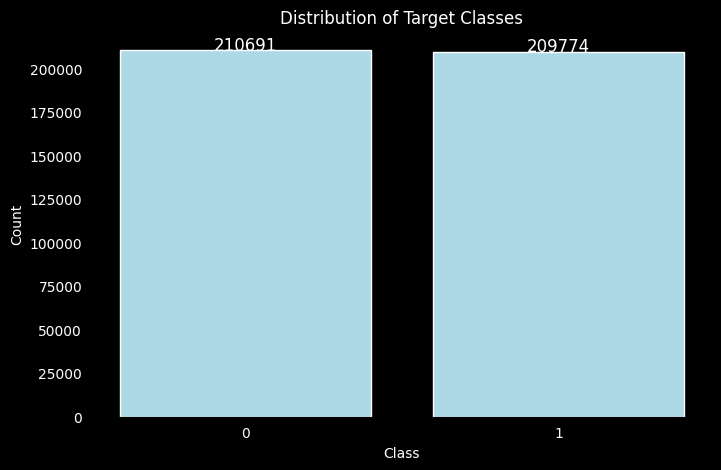

In [22]:
import matplotlib.pyplot as plt

df = data[['target']].copy()

# Comptage des classes
counts = df['target'].value_counts()

plt.figure(figsize=(8,5), facecolor='black')

# Bar plot
bars = plt.bar(counts.index.astype(str), counts.values, color='lightblue', edgecolor='white')

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
             ha='center', color='white', fontsize=12)

# Titres et labels
plt.title("Distribution of Target Classes", color='white')
plt.xlabel("Class", color='white')
plt.ylabel("Count", color='white')

# Ticks en blanc
plt.xticks(color='white')
plt.yticks(color='white')

# Fond noir
plt.gca().set_facecolor('black')

plt.show()


In [3]:
data = data.drop(columns=["close", "quote_asset_volume", "taker_buy_quote"])

# feature engineering avec ajout de variables laggées
for col in data.columns:
    if col != "target":
        for lag in range(1, 3):
            data[f"{col}_lag_{lag}"] = data[col].shift(lag) 

data = data.dropna()
print(data.columns)

Index(['high', 'low', 'volume', 'number_of_trades', 'return', 'target',
       'EMA_12', 'MACD', 'MACD_Signal', 'BB_width', 'RSI_14', 'ATR_14',
       'High_Low_Range', 'Buy_Pressure', 'Volume_Pressure',
       'Realized_Volatility', 'high_lag_1', 'high_lag_2', 'low_lag_1',
       'low_lag_2', 'volume_lag_1', 'volume_lag_2', 'number_of_trades_lag_1',
       'number_of_trades_lag_2', 'return_lag_1', 'return_lag_2',
       'EMA_12_lag_1', 'EMA_12_lag_2', 'MACD_lag_1', 'MACD_lag_2',
       'MACD_Signal_lag_1', 'MACD_Signal_lag_2', 'BB_width_lag_1',
       'BB_width_lag_2', 'RSI_14_lag_1', 'RSI_14_lag_2', 'ATR_14_lag_1',
       'ATR_14_lag_2', 'High_Low_Range_lag_1', 'High_Low_Range_lag_2',
       'Buy_Pressure_lag_1', 'Buy_Pressure_lag_2', 'Volume_Pressure_lag_1',
       'Volume_Pressure_lag_2', 'Realized_Volatility_lag_1',
       'Realized_Volatility_lag_2'],
      dtype='object')


In [ ]:
# Application du modèle xgboost avec validation croisée glissante grâce à la classe CryptoModel
import warnings
warnings.filterwarnings("ignore")   

model = CryptoModel(data, lag=1)
results = model.rolling_xgboost(months_train=6, weeks_test=4, n_trials=50)

In [18]:
results.to_csv("../data/results_xgboost.csv", index=False)

In [17]:
# analyse des résultats
results_xgboost = pd.read_csv("../data/results_xgboost.csv")
print("=== Moyennes globales ===")
print(results_xgboost[["accuracy", "f1", "roc_auc"]].mean())

=== Moyennes globales ===
accuracy    0.523142
f1          0.546986
roc_auc     0.531515
dtype: float64


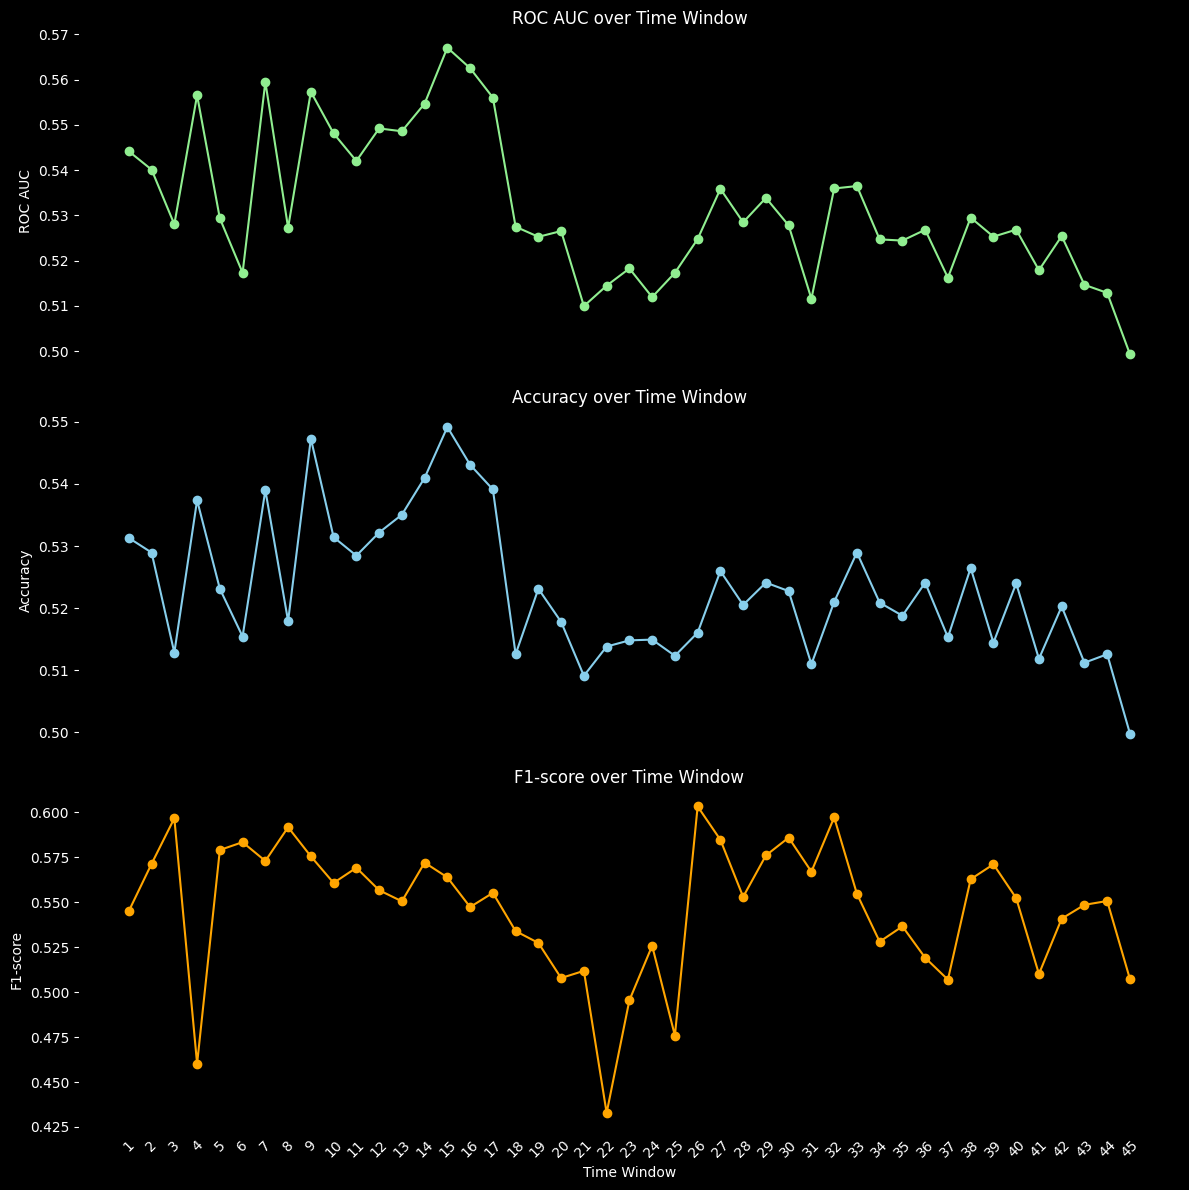

In [18]:
import matplotlib.pyplot as plt

# Données
x = results_xgboost["test_end"]
y_roc = results_xgboost["roc_auc"]
y_acc = results_xgboost["accuracy"]
y_f1 = results_xgboost["f1"]

# Création de 3 sous-graphes
fig, axes = plt.subplots(3, 1, figsize=(12, 12), facecolor='black', sharex=True)

# --- ROC AUC ---
axes[0].plot(x, y_roc, marker="o", color="lightgreen", linestyle='-')
axes[0].set_title("ROC AUC over Time Window", color='white')
axes[0].set_ylabel("ROC AUC", color='white')
axes[0].set_facecolor('black')
axes[0].tick_params(axis='y', colors='white')

# --- Accuracy ---
axes[1].plot(x, y_acc, marker="o", color="skyblue", linestyle='-')
axes[1].set_title("Accuracy over Time Window", color='white')
axes[1].set_ylabel("Accuracy", color='white')
axes[1].set_facecolor('black')
axes[1].tick_params(axis='y', colors='white')

# --- F1-score ---
axes[2].plot(x, y_f1, marker="o", color="orange", linestyle='-')
axes[2].set_title("F1-score over Time Window", color='white')
axes[2].set_xlabel("Time Window", color='white')
axes[2].set_ylabel("F1-score", color='white')
axes[2].set_facecolor('black')
axes[2].tick_params(axis='y', colors='white')

# Axes x : ticks uniquement sur les points
tick_indices = range(0, len(x), 1)  # ici tous les points, tu peux mettre 2,3... pour espacer
axes[2].set_xticks(tick_indices)
axes[2].set_xticklabels(range(1, len(x)+1), color='white', rotation=45)

# Grilles désactivées
for ax in axes:
    ax.grid(False)

plt.tight_layout()
plt.show()


/var/folders/_w/2y4ytldn4yg8zlk064ghy39w0000gn/T/ipykernel_26088/43237655.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_seq.append(y[i+n_steps])
/Users/noe/Documents/BigData S.Barthelemy/crypto-price-movement-intraday-prediction/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5107 - auc: 0.5144 - loss: 0.6977 - precision: 0.5093 - recall: 0.4879

1314/1314 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.5131 - auc: 0.5178 - loss: 0.6944 - precision: 0.5126 - recall: 0.4922 - val_accuracy: 0.5083 - val_auc: 0.5152 - val_loss: 0.6932 - val_precision: 0.5041 - val_recall: 0.8661
Epoch 2/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5193 - auc: 0.5261 - loss: 0.6924 - precision: 0.5182 - recall: 0.4991

1314/1314 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.5185 - auc: 0.5258 - loss: 0.6924 - precision: 0.5180 - recall: 0.5025 - val_accuracy: 0.5097 - val_auc: 0.5153 - val_loss: 0.6928 - val_precision: 0.5113 - val_recall: 0.3856
Epoch 3/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.5202 - auc: 0.5275 - loss: 0.6921 - precision: 0.5204 - recall: 0.4906 - val_accuracy: 0.5081 - val_auc: 0.5149 - val_loss: 0.6930 - val_precision: 0.5044 - val_recall: 0.8006
Epoch 4/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.5197 - auc: 0.5269 - loss: 0.6923 - precision: 0.5196 - recall: 0.4934 - val_accuracy: 0.5047 - val_auc: 0.5134 - val_loss: 0.6930 - val_precision: 0.5020 - val_recall: 0.8873
Epoch 5/50
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5231 - auc: 0.5302 - loss: 0.6918 - precision: 0.5230 - recall: 0.4859

1314/1314 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.5222 - auc: 0.5299 - loss: 0.6918 - precision: 0.5224 - recall: 0.4927 - val_accuracy: 0.5108 - val_auc: 0.5158 - val_loss: 0.6927 - val_precision: 0.5122 - val_recall: 0.4093
Epoch 6/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.5221 - auc: 0.5306 - loss: 0.6917 - precision: 0.5221 - recall: 0.4987 - val_accuracy: 0.5122 - val_auc: 0.5176 - val_loss: 0.6928 - val_precision: 0.5134 - val_recall: 0.4242
Epoch 7/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5238 - auc: 0.5324 - loss: 0.6916 - precision: 0.5234 - recall: 0.4936

1314/1314 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.5223 - auc: 0.5317 - loss: 0.6916 - precision: 0.5223 - recall: 0.4995 - val_accuracy: 0.5135 - val_auc: 0.5173 - val_loss: 0.6927 - val_precision: 0.5100 - val_recall: 0.6348
Epoch 8/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.5226 - auc: 0.5325 - loss: 0.6915 - precision: 0.5227 - recall: 0.4957 - val_accuracy: 0.5010 - val_auc: 0.5137 - val_loss: 0.6940 - val_precision: 0.4999 - val_recall: 0.9511
Epoch 9/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.5241 - auc: 0.5340 - loss: 0.6913 - precision: 0.5238 - recall: 0.5082 - val_accuracy: 0.5124 - val_auc: 0.5168 - val_loss: 0.6927 - val_precision: 0.5120 - val_recall: 0.4790
Epoch 10/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.5242 - auc: 0.5344 - loss: 0.6913 - precision: 0.5238 - recall: 0.5112 - val_accuracy: 0.5082 - val_auc: 0.5119 - val_loss: 0.6933 - val_precision: 0.5043 - val_recall: 0.8291
Epoch 11/50
1314/1314 ━━━━

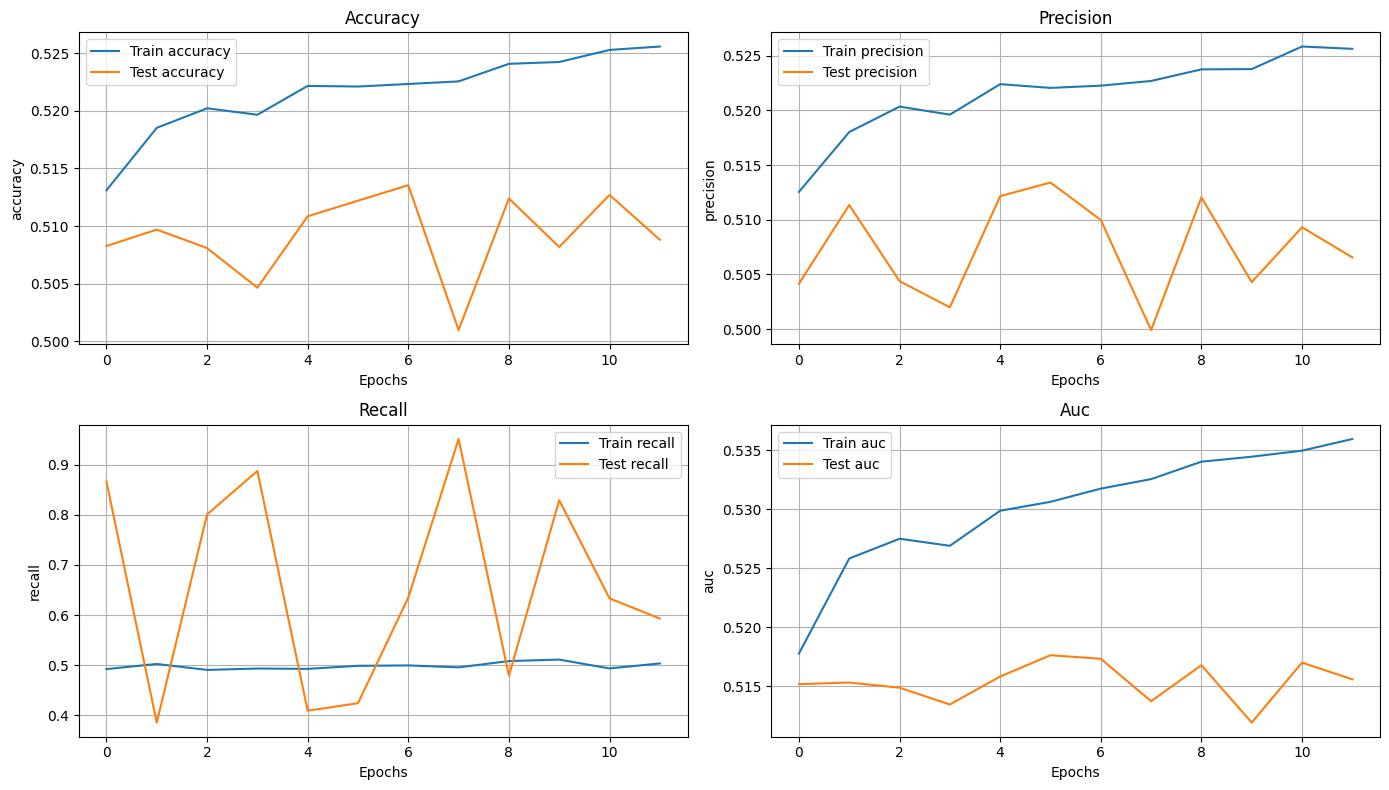


===== ÉVALUATION TEST =====
Test Loss: 0.6927
Test Accuracy: 0.5135
Test Precision: 0.5100
Test Recall: 0.6348
Test AUC: 0.5173


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
import random, os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# =====================================================================
# 1️⃣ Reproductibilité
# =====================================================================
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# =====================================================================
# 2️⃣ Préparation des données
# =====================================================================
df = data[['high', 'low', 'volume', 'number_of_trades', 'return', 'target',
       'EMA_12', 'MACD', 'MACD_Signal', 'BB_width', 'RSI_14', 'ATR_14',
       'High_Low_Range', 'Buy_Pressure', 'Volume_Pressure',
       'Realized_Volatility']].copy() 

SEQ_LENGTH = 24  # 24 pas de temps (2 heures)

# features et cible
X = df.drop('target', axis=1)
y = df['target']

# Normalisation
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Sauvegarde du scaler pour usage futur
joblib.dump(scaler, 'scaler.pkl')

# Création des séquences temporelles
def create_sequences(X, y, n_steps=SEQ_LENGTH):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i+n_steps])
        y_seq.append(y[i+n_steps])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, n_steps=SEQ_LENGTH)

# Découpage chronologique : train/test
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# =====================================================================
# 3️⃣ Modèle LSTM
# =====================================================================
model = Sequential([
    LSTM(64, input_shape=(SEQ_LENGTH, X_train.shape[2]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(32),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# =====================================================================
# 4️⃣ Callbacks
# =====================================================================
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.h5', save_best_only=True)
]

# =====================================================================
# 5️⃣ Entraînement (avec suivi validation sur test)
# =====================================================================
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_test, y_test),  # suivi sur test pour les courbes
    callbacks=callbacks,
    verbose=1
)

# =====================================================================
# 6️⃣ Suivi des performances
# =====================================================================
def plot_history(history):
    metrics = ['accuracy', 'precision', 'recall', 'auc']
    plt.figure(figsize=(14, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Test {metric}')
        plt.title(metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

# =====================================================================
# 7️⃣ Évaluation finale sur le test
# =====================================================================
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test, verbose=0)
print("\n===== ÉVALUATION TEST =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
